In [144]:
import os
import torch
from mantis.models.intern_vl_25_8b import InternVLChatProcessor, InternLM2Tokenizer
attention_file = "./scripts/attention_mochi_g8_f8.pt"
input_ids_file = "./scripts/input_ids_mochi_g8_f8.pt"   
past_key_values_file = "./scripts/past_key_values_mochi_g8_f8.pt"
# Load attention tensor
attentions = torch.load(attention_file)
input_ids = torch.load(input_ids_file)
past_key_values = torch.load(past_key_values_file)

print(f"Number of attentions: {len(attentions)}")
print(f"len(attentions[0]): {len(attentions[0])}")
print(f"attentions[0][0].shape: {attentions[0][0].shape}")
print(f"attentions[0][1].shape: {attentions[0][1].shape}")
print(f"input_ids.shape: {input_ids.shape}")
local_self_attn = [x[0].mean(dim=(0, 1)) for x in attentions]
text_to_kv_attn = [x[1].mean(dim=(0, 1)) for x in attentions]
model_path = 'OpenGVLab/InternVL2_5-8B'
tokenizer = InternLM2Tokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)
processor = InternVLChatProcessor(tokenizer, enable_cross_attention=True, max_num_patches=1)

assert input_ids.shape[0] == 1, "Only support batch size 1"
selected = (input_ids == processor.img_context_token_id) | (input_ids == processor.img_start_token_id) | (input_ids == processor.img_end_token_id) | (input_ids == processor.bos_token_id)
reranged_input_ids = torch.cat([input_ids[selected], input_ids[~selected]])
tokens = tokenizer.convert_ids_to_tokens(reranged_input_ids)
input_ids = reranged_input_ids.unsqueeze(0)
max_token_len = max(len(token) for token in tokens)

Number of attentions: 32
len(attentions[0]): 2
attentions[0][0].shape: torch.Size([1, 32, 2065, 2065])
attentions[0][1].shape: torch.Size([1, 32, 310, 2375])
input_ids.shape: torch.Size([1, 2375])


In [152]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from tqdm import tqdm
from pathlib import Path

def plot_heatmap(attn: torch.Tensor, save_path="./fig.png", title="Attention Heatmap", vmin=None, vmax=None, figsize=None):
    # Convert mean attention tensor to numpy array
    attention_data = attn.float().cpu().numpy()
    print(f"attention_data.shape: {attention_data.shape}")
    q_len, k_len = attention_data.shape
    
    if figsize is None:
        # Calculate figure size
        q_size = max(int(q_len // 50), 2)
        k_size = max(int(k_len // 50), 6)
        figsize = (k_size, q_size)
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    print(f"figsize: {fig.get_size_inches()}")

    # Create heatmap with log scaling
    heatmap = ax.imshow(attention_data, cmap='viridis', aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))  
    ax.grid(False)

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Attention Weight (Log Scale)')

    # Set labels and title
    ax.set_xlabel('KV Tokens')
    ax.set_ylabel('Query Tokens')
    ax.set_title(title)

    # Save the plot
    plt.show()
    plt.close()

sum of weights: tensor(1., dtype=torch.bfloat16)
idx attention weights
1    -> <s>          : 0.30273438
2    -> <img>        : 0.03564453
3    -> <IMG_CONTEXT>: 0.01312256
4    -> <IMG_CONTEXT>: 0.01550293
5    -> <IMG_CONTEXT>: 0.00405884
6    -> <IMG_CONTEXT>: 0.00607300
7    -> <IMG_CONTEXT>: 0.00067902
8    -> <IMG_CONTEXT>: 0.00262451
9    -> <IMG_CONTEXT>: 0.00619507
10   -> <IMG_CONTEXT>: 0.00570679
11   -> <IMG_CONTEXT>: 0.00118256
12   -> <IMG_CONTEXT>: 0.00046539
13   -> <IMG_CONTEXT>: 0.00027657
14   -> <IMG_CONTEXT>: 0.00143433
15   -> <IMG_CONTEXT>: 0.00213623
16   -> <IMG_CONTEXT>: 0.00041580
17   -> <IMG_CONTEXT>: 0.00093079
18   -> <IMG_CONTEXT>: 0.00381470
19   -> <IMG_CONTEXT>: 0.00161743
20   -> <IMG_CONTEXT>: 0.00037766
21   -> <IMG_CONTEXT>: 0.00085449
22   -> <IMG_CONTEXT>: 0.00065994
23   -> <IMG_CONTEXT>: 0.00059891
24   -> <IMG_CONTEXT>: 0.00046158
25   -> <IMG_CONTEXT>: 0.00405884
26   -> <IMG_CONTEXT>: 0.00067902
27   -> <IMG_CONTEXT>: 0.00049210
28   -> <IM

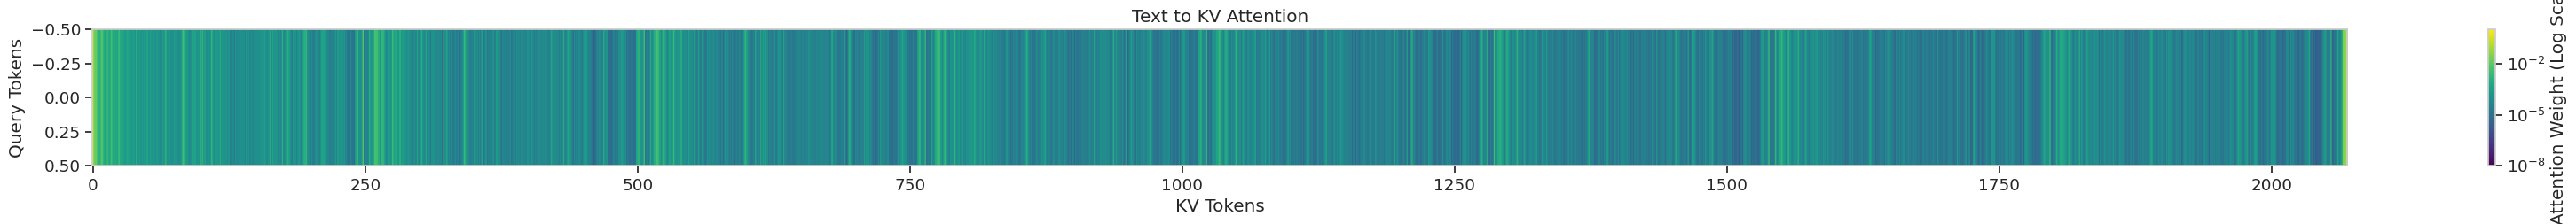

In [170]:
# get the attention weights in each row
k =  258*8+5
layer_idx = 31
if k >= local_self_attn[layer_idx].shape[0]:
    weights = text_to_kv_attn[layer_idx][k-local_self_attn[layer_idx].shape[0], :k+1]
    delta_weights = weights - text_to_kv_attn[layer_idx][k-1-local_self_attn[layer_idx].shape[0], :k+1]
else:
    weights = local_self_attn[layer_idx][k, :k+1]
    delta_weights = weights - local_self_attn[layer_idx][k-1, :k+1]
    print(f"num_higher_weights: {(delta_weights > 0).sum()}")
print("sum of weights:", weights.sum())     
print("idx attention weights")
for i, (token, weight) in enumerate(zip(tokens, weights)):
    token_id = str(i+1).ljust(len(str(len(tokens))))
    print(f"{token_id} -> {token.ljust(max_token_len)}: {weight:.8f}")
vmin = 1e-8
vmax = 1
print(f"vmin: {vmin}, vmax: {vmax}")

plot_heatmap(weights.unsqueeze(0), title="Text to KV Attention", vmin=vmin, vmax=vmax)

sum of weights: tensor(1., dtype=torch.bfloat16)
idx attention weights
current_token ，
1    -> <s>          : 0.40234375
2    -> <img>        : 0.00282288
3    -> <IMG_CONTEXT>: 0.00078964
4    -> <IMG_CONTEXT>: 0.00090408
5    -> <IMG_CONTEXT>: 0.00090027
6    -> <IMG_CONTEXT>: 0.00056458
7    -> <IMG_CONTEXT>: 0.00013542
8    -> <IMG_CONTEXT>: 0.00042915
9    -> <IMG_CONTEXT>: 0.00116730
10   -> <IMG_CONTEXT>: 0.00063324
11   -> <IMG_CONTEXT>: 0.00010490
12   -> <IMG_CONTEXT>: 0.00008631
13   -> <IMG_CONTEXT>: 0.00003839
14   -> <IMG_CONTEXT>: 0.00018692
15   -> <IMG_CONTEXT>: 0.00070190
16   -> <IMG_CONTEXT>: 0.00014114
17   -> <IMG_CONTEXT>: 0.00025749
18   -> <IMG_CONTEXT>: 0.00146484
19   -> <IMG_CONTEXT>: 0.00043106
20   -> <IMG_CONTEXT>: 0.00032806
21   -> <IMG_CONTEXT>: 0.00042534
22   -> <IMG_CONTEXT>: 0.00019073
23   -> <IMG_CONTEXT>: 0.00014973
24   -> <IMG_CONTEXT>: 0.00022221
25   -> <IMG_CONTEXT>: 0.00093460
26   -> <IMG_CONTEXT>: 0.00024796
27   -> <IMG_CONTEXT>: 0.0001

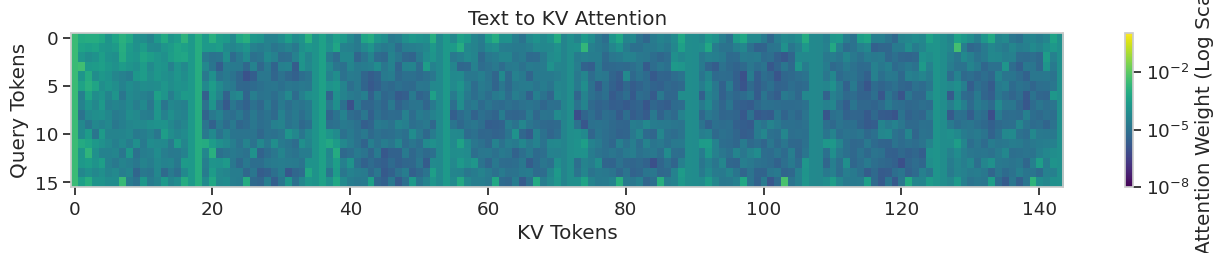

In [182]:
# plot the attention in image 16 x 16 view
k =  258*8+50
layer_idx = 31
if k >= local_self_attn[layer_idx].shape[0]:
    weights = text_to_kv_attn[layer_idx][k-local_self_attn[layer_idx].shape[0], :k+1]
    delta_weights = weights - text_to_kv_attn[layer_idx][k-1-local_self_attn[layer_idx].shape[0], :k+1]
else:
    weights = local_self_attn[layer_idx][k, :k+1]
    delta_weights = weights - local_self_attn[layer_idx][k-1, :k+1]
    print(f"num_higher_weights: {(delta_weights > 0).sum()}")
print("sum of weights:", weights.sum())     
print("idx attention weights")
print("current_token", tokens[k])
for i, (token, weight) in enumerate(zip(tokens, weights)):
    token_id = str(i+1).ljust(len(str(len(tokens))))
    print(f"{token_id} -> {token.ljust(max_token_len)}: {weight:.8f}")
vmin = 1e-8
vmax = 1
print(f"vmin: {vmin}, vmax: {vmax}")

# 16 * 16
_input_ids = input_ids[0][:k+1]
selected = (_input_ids == processor.img_context_token_id) | (_input_ids == processor.img_start_token_id) | (_input_ids == processor.img_end_token_id)
selected = selected.to(weights.device)
weights = weights[selected]
if weights.shape[0] % 258 != 0:
    weights = weights[:-(weights.shape[0] % 258)]
weights = weights.view(-1, 258)

weights = torch.cat([
    weights[:, 0].reshape(-1, 1, 1).repeat(1, 16, 1),
    weights[:, 1:1+256].view(-1, 16, 16),
    weights[:, -1].reshape(-1, 1, 1).repeat(1, 16, 1)
], dim=2)
weights = weights.view(-1, 16, 18).transpose(0, 1).flatten(1, 2)
print(f"weights.shape: {weights.shape}")
plot_heatmap(weights, title="Text to KV Attention", vmin=vmin, vmax=vmax, figsize=(16, 2))

num_higher_weights: 48
sum of weights: tensor(0.2070, dtype=torch.bfloat16)
delta of sum of weights: tensor(-0.0835, dtype=torch.bfloat16)
Current token that is attended: 51 <IMG_CONTEXT>
idx attention weights

51   -> <IMG_CONTEXT>: 0.00299072
52   -> <IMG_CONTEXT>: 0.03588867
53   -> <IMG_CONTEXT>: 0.01940918
54   -> <IMG_CONTEXT>: 0.00622559
55   -> <IMG_CONTEXT>: 0.00457764
56   -> <IMG_CONTEXT>: 0.00265503
57   -> <IMG_CONTEXT>: 0.00164795
58   -> <IMG_CONTEXT>: 0.00166321
59   -> <IMG_CONTEXT>: 0.00138092
60   -> <IMG_CONTEXT>: 0.00120544
61   -> <IMG_CONTEXT>: 0.00177002
62   -> <IMG_CONTEXT>: 0.00130463
63   -> <IMG_CONTEXT>: 0.00118256
64   -> <IMG_CONTEXT>: 0.00069046
65   -> <IMG_CONTEXT>: 0.00079346
66   -> <IMG_CONTEXT>: 0.00149536
67   -> <IMG_CONTEXT>: 0.00119781
68   -> <IMG_CONTEXT>: 0.00073624
69   -> <IMG_CONTEXT>: 0.00067520
70   -> <IMG_CONTEXT>: 0.00062561
71   -> <IMG_CONTEXT>: 0.00056458
72   -> <IMG_CONTEXT>: 0.00028229
73   -> <IMG_CONTEXT>: 0.00046349
74   ->

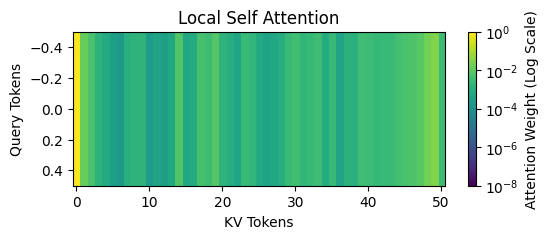

In [4]:
k =  50
offset = 0
layer_idx = 0
if k >= local_self_attn[layer_idx].shape[0]:
    weights = text_to_kv_attn[layer_idx][k+offset:, k]
    delta_weights = weights - text_to_kv_attn[layer_idx][k-1+offset:, k] if k > 0 else weights
else:
    weights = local_self_attn[layer_idx][k+offset:, k]
    delta_weights = weights - local_self_attn[layer_idx][k+offset:, k-1] if k > 0 else weights
    print(f"num_higher_weights: {(delta_weights > 0).sum()}")
cur_tokens = tokens[k:]
print("sum of weights:", weights.sum())
print("delta of sum of weights:", delta_weights.sum())
print("Current token that is attended:", k+1, cur_tokens[0])
print("idx attention weights")
print()
for i, (token, weight) in enumerate(zip(cur_tokens, weights)):
    token_id = k + i
    token_id = str(token_id+1).ljust(len(str(len(tokens))))
    print(f"{token_id} -> {token.ljust(max_token_len)}: {weight:.8f}")
vmin = 1e-8
vmax = 1
print(f"vmin: {vmin}, vmax: {vmax}")
if k >= local_self_attn[layer_idx].shape[0]:
    plot_heatmap(text_to_kv_attn[layer_idx][k+offset:, k].unsqueeze(0), title="Text to KV Attention", vmin=vmin, vmax=vmax)
else:
    plot_heatmap(local_self_attn[layer_idx][k, :k+1].unsqueeze(0), title="Local Self Attention", vmin=vmin, vmax=vmax)

In [5]:
# horizontal
layer_idx = 0
top_k_to_print = 300
# analysis the tokens where the later tokens always have consistent attention weights
to_attend_weights_deltas = {}
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i, :i+1] # lower, the more biased the current token will attend to the previous tokens
    to_attend_weights_deltas[i] = weights.std().item()
    # to_attend_weights_deltas[i] = ((weights - local_self_attn[layer_idx][i-1, :i+1] if i > 0 else weights) > 0).sum().item()   # higher, the more previous tokens this token attends to 
    to_attend_weights_deltas[i] /= len(weights)

sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=False)
print(f"Top {top_k_to_print} tokens who attention scores of previous tokens have the lowest variance (horizontal highlights)")
for i, (idx, var) in enumerate(sorted_to_attend_weights_deltas[:top_k_to_print]):
    print(f"{idx} -> {tokens[idx].ljust(max_token_len)}: {var:.8f}")

Top 300 tokens who attention scores of previous tokens have the lowest variance (horizontal highlights)
0 -> <s>          : nan
1807 -> <img>        : 0.00000144
2064 -> </img>       : 0.00000174
1549 -> <img>        : 0.00000199
1806 -> </img>       : 0.00000225
1291 -> <img>        : 0.00000286
1548 -> </img>       : 0.00000307
2048 -> <IMG_CONTEXT>: 0.00000414
1290 -> </img>       : 0.00000440
1033 -> <img>        : 0.00000440
1790 -> <IMG_CONTEXT>: 0.00000508
2049 -> <IMG_CONTEXT>: 0.00000515
1532 -> <IMG_CONTEXT>: 0.00000645
1032 -> </img>       : 0.00000677
1791 -> <IMG_CONTEXT>: 0.00000688
1823 -> <IMG_CONTEXT>: 0.00000689
2001 -> <IMG_CONTEXT>: 0.00000707
2000 -> <IMG_CONTEXT>: 0.00000714
1837 -> <IMG_CONTEXT>: 0.00000714
2016 -> <IMG_CONTEXT>: 0.00000729
2054 -> <IMG_CONTEXT>: 0.00000737
2063 -> <IMG_CONTEXT>: 0.00000751
1854 -> <IMG_CONTEXT>: 0.00000760
775 -> <img>        : 0.00000771
1895 -> <IMG_CONTEXT>: 0.00000773
1829 -> <IMG_CONTEXT>: 0.00000777
1845 -> <IMG_CONTEXT>: 

/tmp/ipykernel_2036673/1652644347.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  to_attend_weights_deltas[i] = weights.std().item()


### Attention weights reconstruction

In [188]:
def get_top_k_idxs_to_predict(layer_idx, top_k=100, do_print=True, predict_type="attention_weights"):
    if predict_type == "salient_tokens":
        # to_attend_weights_deltas = {}
        # for i in range(len(local_self_attn[layer_idx])):
        #     weights = local_self_attn[layer_idx][i:, i] # lower, the more biased the current token will attend to the previous tokens
        #     # to_attend_weights_deltas[i] = weights.std().item()
        #     to_attend_weights_deltas[i] = weights.std().item() + weights.sum().item()
        #     # to_attend_weights_deltas[i] = ((weights - local_self_attn[layer_idx][i:, i-1] if i > 0 else weights) > 0).sum().item() # higher, the more previous tokens this token attends to 
        #     # to_attend_weights_deltas[i] = weights.sum().item() # higher, the more important this token is to the later tokens
        #     to_attend_weights_deltas[i] /= len(weights)

        # sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=True)
        # top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k]]
        slident_value = []
        for i in range(len(local_self_attn[layer_idx])):
            weights = local_self_attn[layer_idx][i:, i]
            slident_value.append(weights.std().item() + weights.mean().item())
        top_k_idxs = sorted(range(len(slident_value)), key=lambda x: slident_value[x], reverse=True)[:top_k]
                
    elif predict_type == "attention_weights":
        mean_weights = []
        for i in range(len(local_self_attn[layer_idx])):
            weights = local_self_attn[layer_idx][i:, i]
            mean_weights.append(weights.mean().item())
        top_k_idxs = sorted(range(len(mean_weights)), key=lambda x: mean_weights[x], reverse=True)[:top_k]
        
    elif predict_type == "vector_norms":
        cur_layer_value_vectors = past_key_values[layer_idx][1][0].transpose(0, 1).flatten(1, 2)
        local_self_attn_value_vectors = cur_layer_value_vectors[:local_self_attn[layer_idx].shape[0]]
        vector_norms = local_self_attn_value_vectors.norm(2, dim=-1)
        top_k_idxs = vector_norms.argsort(descending=True)[:top_k].tolist()
    elif predict_type == "key_norms":
        cur_layer_key_vectors = past_key_values[layer_idx][0][0].transpose(0, 1).flatten(1, 2)
        local_self_attn_key_vectors = cur_layer_key_vectors[:local_self_attn[layer_idx].shape[0]]
        key_norms = local_self_attn_key_vectors.norm(2, dim=-1)
        top_k_idxs = key_norms.argsort(descending=True)[:top_k].tolist()
    elif predict_type == "output_norms":
        # use the output, i.e. the attention weighted value vectors
        weights = local_self_attn[layer_idx] # (N, N), (Q, K)
        cur_layer_value_vectors = past_key_values[layer_idx][1][0].transpose(0, 1).flatten(1, 2) # (B, N, C)
        local_self_attn_value_vectors = cur_layer_value_vectors[:local_self_attn[layer_idx].shape[0]] # (N, C)
        print(weights.shape, local_self_attn_value_vectors.shape)
        result = weights.to(local_self_attn_value_vectors.device) @ local_self_attn_value_vectors # (N, C)
        # result = result.norm(2, dim=-1)
        result = result.abs().max(dim=-1).values
        top_k_idxs = result.argsort(descending=True)[:top_k].tolist()
    elif predict_type == "weighted_norms":
        weights = local_self_attn[layer_idx]
        cur_layer_value_vectors = past_key_values[layer_idx][1][0].transpose(0, 1).flatten(1, 2)
        local_self_attn_value_vectors = cur_layer_value_vectors[:local_self_attn[layer_idx].shape[0]]
        pass
    else:
        raise ValueError(f"Unknown predict type: {predict_type}")        
    if do_print:
        print(f"Top {top_k} tokens with the highest variance of attention weights")
        for i, idx in enumerate(top_k_idxs):
            print(f"{idx} -> {tokens[idx].ljust(max_token_len)}")
    return top_k_idxs

def get_oracle_top_k_idxs_to_predict(layer_idx, top_k=100, do_print=True, oracle_type="attention_weights"):
    """
    oracle_type: attention_weights, vector_norms, attention_weighted_vector_norm
    """
    to_attend_weights_deltas = {}
    
    cur_layer_value_vectors = past_key_values[layer_idx][1][0].transpose(0, 1).flatten(1, 2)
    local_self_attn_value_vectors = cur_layer_value_vectors[:local_self_attn[layer_idx].shape[0]]
    vector_norms = local_self_attn_value_vectors.norm(2, dim=-1)
    weights = text_to_kv_attn[layer_idx][:, :len(local_self_attn[layer_idx])]
    if oracle_type == "attention_weights":
        top_k_idxs = weights.mean(dim=0).argsort(descending=True)[:top_k].tolist() # select the tokens with the highest attention weights
    elif oracle_type == "vector_norms":
        top_k_idxs = vector_norms.argsort(descending=True)[:top_k].tolist() # select the tokens with the highest value vector norm
    elif oracle_type == "attention_weighted_vector_norms":
        result = weights.unsqueeze(-1).to(local_self_attn_value_vectors.device) * local_self_attn_value_vectors.unsqueeze(0)
        result = result.norm(2, dim=-1).softmax(dim=-1).mean(dim=0)
        top_k_idxs = result.argsort(descending=True)[:top_k].tolist()
        
        # result = weights.to(local_self_attn_value_vectors.device) @ local_self_attn_value_vectors
        # result = result.norm(2, dim=-1)
        # top_k_idxs = result.argsort(descending=True)[:top_k].tolist() # select the tokens with the highest attention weights
    else:
        raise ValueError(f"Unknown oracle type: {oracle_type}")
    if do_print:
        print(f"Top {top_k} tokens with the highest variance of attention weights")
        for i, idx in enumerate(top_k_idxs):
            print(f"{idx} -> {tokens[idx].ljust(max_token_len)}")
    return top_k_idxs

top_k_to_print = 500 # 2048 -> 100
top_k_idxs = get_top_k_idxs_to_predict(0, top_k_to_print, do_print=False, predict_type="output_norms")
oracle_top_k_idxs = get_oracle_top_k_idxs_to_predict(0, top_k_to_print, do_print=False, oracle_type="attention_weighted_vector_norms")
# QKV intputs, V, 
# outputs (B, N, C) # vectors of v

torch.Size([2065, 2065]) torch.Size([2065, 1024])


In [38]:
layer_idx = 31
top_k_to_print = 1 # 2048 -> 500
# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
def estimate_attention_error(layer_idx, top_k_idxs, error_type="attention_weights", metric="l2_norm", normalize_weights=True):
    if error_type == "attention_weights":
        reproduced_weights = []
        for i in range(len(local_self_attn[layer_idx])):
            weights = local_self_attn[layer_idx][i, top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
            reproduced_weights.append(weights.sum().item())
            # reproduced_weights.append(weights.sum().item())
        # print(reproduced_weights)
        local_self_attn_error = (1 - torch.tensor(reproduced_weights)).abs().mean().item()
        # print(f"local attn error:", local_self_attn_error)
        # print("sum of reproduced weights:", sum(reproduced_weights))

        # test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
        text_to_kv_top_k_idxs = top_k_idxs + [i+local_self_attn[layer_idx].shape[0] for i in range(text_to_kv_attn[layer_idx].shape[0])]
        reproduced_weights = []
        for i in range(len(text_to_kv_attn[layer_idx])):
            weights = text_to_kv_attn[layer_idx][i, text_to_kv_top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
            reproduced_weights.append(weights.sum().item())
            # reproduced_weights.append(weights.sum().item())
        # print(reproduced_weights)
        text_to_kv_error = (1 - torch.tensor(reproduced_weights)).abs().mean().item()
        # print(f"text to kv error:", text_to_kv_error)
        # print("sum of reproduced weights:", sum(reproduced_weights))
        return local_self_attn_error, text_to_kv_error
    elif error_type == "value_vectors":
        cur_layer_value_vectors = past_key_values[layer_idx][1][0].transpose(0, 1).flatten(1, 2)
        local_self_attn_value_vectors = cur_layer_value_vectors[:local_self_attn[layer_idx].shape[0]]
        selected_value_vectors = local_self_attn_value_vectors[top_k_idxs]
        weights = local_self_attn[layer_idx][:, top_k_idxs].to(selected_value_vectors.device)
        # normalize the weights along the last dimension
        if normalize_weights:
            weights = weights / weights.sum(dim=-1, keepdim=True)
        reproduced_output = weights @ selected_value_vectors
        original_output = local_self_attn[layer_idx].to(local_self_attn_value_vectors.device) @ local_self_attn_value_vectors
        if metric == "l2_norm":
            local_self_attn_error = (reproduced_output - original_output).norm(2, dim=-1).mean().item()
        elif metric == "l-inf_norm":
            local_self_attn_error = (reproduced_output - original_output).abs().max(dim=-1).values.mean().item()
        elif metric == "cosine_similarity":
            local_self_attn_error = 1 - torch.nn.functional.cosine_similarity(reproduced_output, original_output, dim=-1).mean().item()
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        text_to_kv_top_k_idxs = top_k_idxs + [i+local_self_attn[layer_idx].shape[0] for i in range(text_to_kv_attn[layer_idx].shape[0])]
        selected_value_vectors = cur_layer_value_vectors[text_to_kv_top_k_idxs]
        weights = text_to_kv_attn[layer_idx][:, text_to_kv_top_k_idxs].to(selected_value_vectors.device)
        # normalize the weights along the last dimension
        if normalize_weights:
            weights = weights / weights.sum(dim=-1, keepdim=True)
        reproduced_output = weights @ selected_value_vectors
        original_output = text_to_kv_attn[layer_idx].to(cur_layer_value_vectors.device) @ cur_layer_value_vectors
        
        if metric == "l2_norm":
            text_to_kv_error = (reproduced_output - original_output).norm(2, dim=-1).mean().item()
        elif metric == "l-inf_norm":
            text_to_kv_error = (reproduced_output - original_output).abs().max(dim=-1).values.mean().item()
        elif metric == "cosine_similarity":
            text_to_kv_error = 1 - torch.nn.functional.cosine_similarity(reproduced_output, original_output, dim=-1).mean().item()
        else:
            raise ValueError(f"Unknown metric: {metric}")
        return local_self_attn_error, text_to_kv_error
    else:
        raise ValueError(f"Unknown error type: {error_type}")
    
        

local_self_attn_error, text_to_kv_error = estimate_attention_error(layer_idx, top_k_idxs, error_type="value_vectors")
print(f"local_self_attn_error: {local_self_attn_error:.8f}, text_to_kv_error: {text_to_kv_error:.8f}")


# sum 1
# sum < 1
# 

local_self_attn_error: 0.08544922, text_to_kv_error: 0.07226562


In [8]:
torch.tensor([1, 2], dtype=torch.float).norm()

tensor(2.2361)

In [9]:
weights[0]

tensor(0.1592, dtype=torch.bfloat16)

In [10]:
local_self_attn[layer_idx].shape

torch.Size([2065, 2065])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def plot_top_k_error(
        source_layer_idx, test_layer_idx, all_top_k, 
        all_local_self_attn_error, all_text_to_kv_error, 
        all_random_local_self_attn_error, all_random_text_to_kv_error,
        all_oracle_local_self_attn_error, all_oracle_text_to_kv_error,
        error_type="attention_weights",
        metric="l2_norm",
        oracle_type="attention_weights",
        predict_type="attention_weights",
        save_dir="plots_attention_weights_error"
        ):
    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.2)

    # Create figure with specific size for better proportions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define a better color palette
    colors = sns.color_palette("viridis", 6)

    # Plot with improved styling 'o-', 's-', '^-', 'D-'
    # ax.plot(all_top_k, all_local_self_attn_error, 'o-', color=colors[0], linewidth=2, 
        # markersize=8, alpha=0.9, label="Local Self Attention")
    ax.plot(all_top_k, all_text_to_kv_error, 's-', color=colors[1], linewidth=2, 
        markersize=8, alpha=0.9, label="Text to KV Attention")
    # ax.plot(all_top_k, all_random_local_self_attn_error, 'o-', color=colors[2], linewidth=2, 
        # markersize=8, alpha=0.9, label="Random Local Self Attention")
    ax.plot(all_top_k, all_random_text_to_kv_error, 's-', color=colors[3], linewidth=2, 
        markersize=8, alpha=0.9, label="Random Text to KV Attention")
    # ax.plot(all_top_k, all_oracle_local_self_attn_error, 'o-', color=colors[4], linewidth=2,
        # markersize=8, alpha=0.9, label="Oracle Local Self Attention")
    ax.plot(all_top_k, all_oracle_text_to_kv_error, 's-', color=colors[5], linewidth=2,
        markersize=8, alpha=0.9, label="Oracle Text to KV Attention")
    

    # Improve labels and title
    
    error_type_pretty_name_map = {
        "attention_weights": "Attention Weights",
        "value_vectors": "Value Vectors",
    }
    metric_pretty_name_map = {
        "l2_norm": "L2 Norm",
        "l-inf_norm": "L-inf Norm",
        "cosine_similarity": "Cosine Similarity",
    }
    oracle_type_pretty_name_map = {
        "attention_weights": "Attention Weights",
        "vector_norms": "Vector Norms",
        "attention_weighted_vector_norms": "Attention Weighted Vector Norms",
    }
    title = f"{error_type_pretty_name_map[error_type]} Error ({metric_pretty_name_map[metric]})"
    title += f"\n(Predict Type: {predict_type})"
    title += f"\n(Oracle: {oracle_type_pretty_name_map[oracle_type]})"
    
    title += f"\n(Source Layer {source_layer_idx} → Test Layer {test_layer_idx})"
    ax.set_xlabel("Top K Tokens", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"Error ({metric_pretty_name_map[metric]})", fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Customize the axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Better legend positioning and styling
    legend = ax.legend(loc='upper right', frameon=True, fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('lightgray')

    # Add a slight padding to the x and y limits for better visualization
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.set_xlim(x_min - (x_max - x_min) * 0.05, x_max + (x_max - x_min) * 0.05)
    ax.set_ylim(y_min - (y_max - y_min) * 0.05, y_max + (y_max - y_min) * 0.05)

    # Tight layout for better spacing
    plt.tight_layout()

    # Save the figure with high DPI (optional)
    # plt.savefig('attention_weights_error.png', dpi=300, bbox_inches='tight')
    save_path = Path(save_dir) / f"error_{source_layer_idx}_{test_layer_idx}_{error_type}_{metric}_{oracle_type}_{predict_type}.png"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()


Analyzing top k tokens:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_2036673/795549089.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  slident_value.append(weights.std().item() + weights.mean().item())
Analyzing top k tokens: 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]


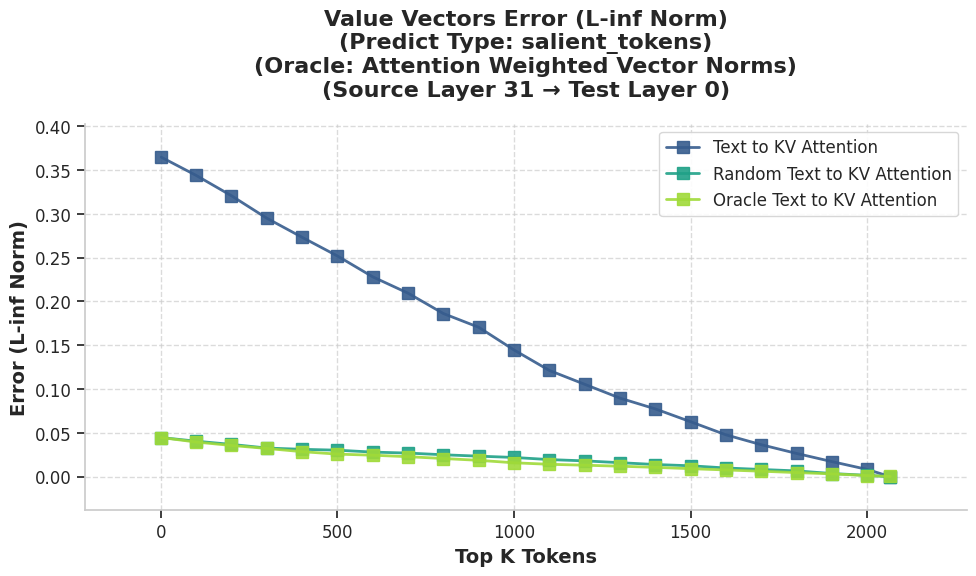

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                  Attention Error Analysis (Source Layer 31 → Test Layer 0)(Error Type: value_vectors, Metric: l-inf_norm, Oracle Type: attention_weighted_vector_norms, Predict Type: salient_tokens)                  |
+--------------+----------------------------+----------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+
| Top K Tokens | Local Self Attention Error | Text to KV Attention Error | Random Local Self Attention Error | Random Text to KV Attention Error | Oracle Local Self Attention Error | Oracle Text to KV Attention Error |
+--------------+----------------------------+----------------------------+-----------------------------------+--------------

In [192]:
import prettytable as pt
# use 31 layer to predict 31 layer, topk from 50, 100, 200, 500, 1000, 2000
source_layer_idx = 31
test_layer_idx = 0
# error_type = "value_vectors" # attention_weights, value_vectors
error_type = "value_vectors" # attention_weights, value_vectors
metric = "l-inf_norm" # l2_norm, l-inf_norm, cosine_similarity
predict_type = "salient_tokens" # salient_tokens, attention_weights, vector_norms, key_norms, output_norms
oracle_type = "attention_weighted_vector_norms"
# oracle_type = "attention_weights"
normalize_weights = False
all_top_k = [1] + list(range(100, local_self_attn[source_layer_idx].shape[0]+100, 100))
all_top_k = [x if x < local_self_attn[source_layer_idx].shape[0] else local_self_attn[source_layer_idx].shape[0] for x in all_top_k]
all_local_self_attn_error = []
all_text_to_kv_error = []
all_random_local_self_attn_error = []
all_random_text_to_kv_error = []
all_oracle_local_self_attn_error = []
all_oracle_text_to_kv_error = []
all_oracle_random_local_self_attn_error = []
all_oracle_random_text_to_kv_error = []
import random
for top_k in tqdm(all_top_k, desc="Analyzing top k tokens"):
    random.seed(0)
    # random_top_k_idxs = random.sample(range(local_self_attn[source_layer_idx].shape[0]), top_k)
    random_top_k_idxs = list(range(top_k))
    top_k_idxs = get_top_k_idxs_to_predict(source_layer_idx, top_k, do_print=False, predict_type=predict_type)
    oracle_top_k_idxs = get_oracle_top_k_idxs_to_predict(source_layer_idx, top_k, do_print=False, oracle_type=oracle_type)
    local_self_attn_error, text_to_kv_error = estimate_attention_error(test_layer_idx, top_k_idxs)
    all_local_self_attn_error.append(local_self_attn_error)
    all_text_to_kv_error.append(text_to_kv_error)
    random_local_self_attn_error, random_text_to_kv_error = estimate_attention_error(test_layer_idx, random_top_k_idxs, error_type=error_type, metric=metric, normalize_weights=normalize_weights)
    all_random_local_self_attn_error.append(random_local_self_attn_error)
    all_random_text_to_kv_error.append(random_text_to_kv_error)
    oracle_local_self_attn_error, oracle_text_to_kv_error = estimate_attention_error(test_layer_idx, oracle_top_k_idxs, error_type=error_type, metric=metric, normalize_weights=normalize_weights)
    all_oracle_local_self_attn_error.append(oracle_local_self_attn_error)
    all_oracle_text_to_kv_error.append(oracle_text_to_kv_error)
# plot
plot_top_k_error(source_layer_idx, test_layer_idx, all_top_k, 
    all_local_self_attn_error, all_text_to_kv_error, 
    all_random_local_self_attn_error, all_random_text_to_kv_error,
    all_oracle_local_self_attn_error, all_oracle_text_to_kv_error,
    error_type=error_type, metric=metric, oracle_type=oracle_type, predict_type=predict_type)

pt_table = pt.PrettyTable()
title = f"Attention Error Analysis (Source Layer {source_layer_idx} → Test Layer {test_layer_idx})(Error Type: {error_type}, Metric: {metric}, Oracle Type: {oracle_type}, Predict Type: {predict_type})"
pt_table.title = title
pt_table.field_names = ["Top K Tokens", "Local Self Attention Error", "Text to KV Attention Error", "Random Local Self Attention Error", "Random Text to KV Attention Error", "Oracle Local Self Attention Error", "Oracle Text to KV Attention Error"]
for top_k, local_self_attn_error, text_to_kv_error, random_local_self_attn_error, random_text_to_kv_error, oracle_local_self_attn_error, oracle_text_to_kv_error in zip(all_top_k, all_local_self_attn_error, all_text_to_kv_error, all_random_local_self_attn_error, all_random_text_to_kv_error, all_oracle_local_self_attn_error, all_oracle_text_to_kv_error):
    pt_table.add_row([
        top_k,
        f"{local_self_attn_error:.5f}",
        f"{text_to_kv_error:.5f}",
        f"{random_local_self_attn_error:.5f}",
        f"{random_text_to_kv_error:.5f}",
        f"{oracle_local_self_attn_error:.5f}",
        f"{oracle_text_to_kv_error:.5f}",
    ])
    
print(pt_table)

# # print pd
# print(f"all_top_k: {all_top_k}")
# print(f"all_local_self_attn_error: {all_local_self_attn_error}")
# print(f"all_text_to_kv_error: {all_text_to_kv_error}")
# print(f"all_random_local_self_attn_error: {all_random_local_self_attn_error}")
# print(f"all_random_text_to_kv_error: {all_random_text_to_kv_error}")
# print(f"all_oracle_local_self_attn_error: {all_oracle_local_self_attn_error}")
# print(f"all_oracle_text_to_kv_error: {all_oracle_text_to_kv_error}")

Analyzing all combinations:   0%|          | 0/72 [00:00<?, ?it/s]

Analyzing error_type: attention_weights, metric: l2_norm, predict_type: salient_tokens, oracle_type: attention_weights


/tmp/ipykernel_2036673/2520924043.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  slident_value.append(weights.std().item() + weights.mean().item())
Analyzing top k tokens: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s]


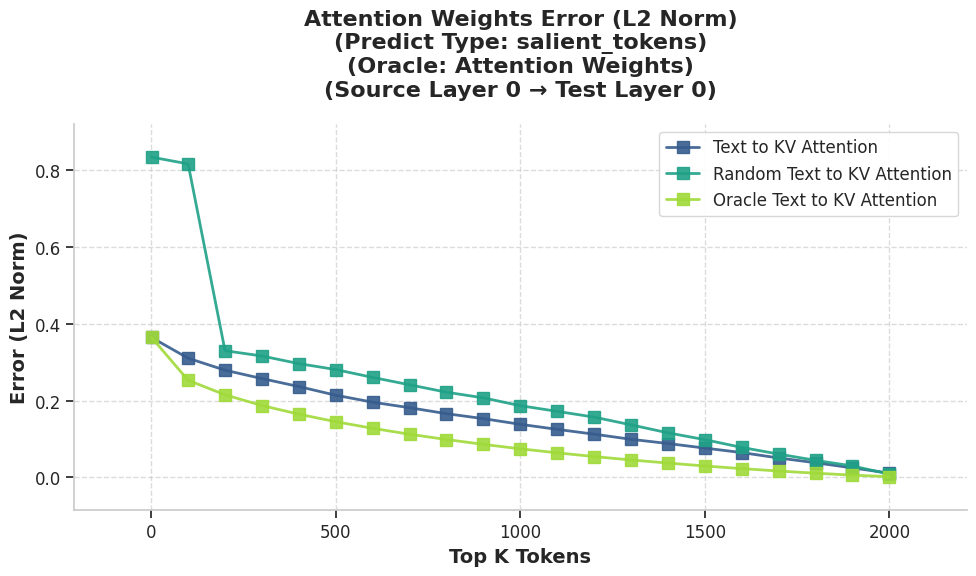

Analyzing all combinations:   1%|▏         | 1/72 [00:16<19:35, 16.55s/it]

Analyzing error_type: attention_weights, metric: l2_norm, predict_type: salient_tokens, oracle_type: vector_norms


/tmp/ipykernel_2036673/2520924043.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  slident_value.append(weights.std().item() + weights.mean().item())
Analyzing top k tokens: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]


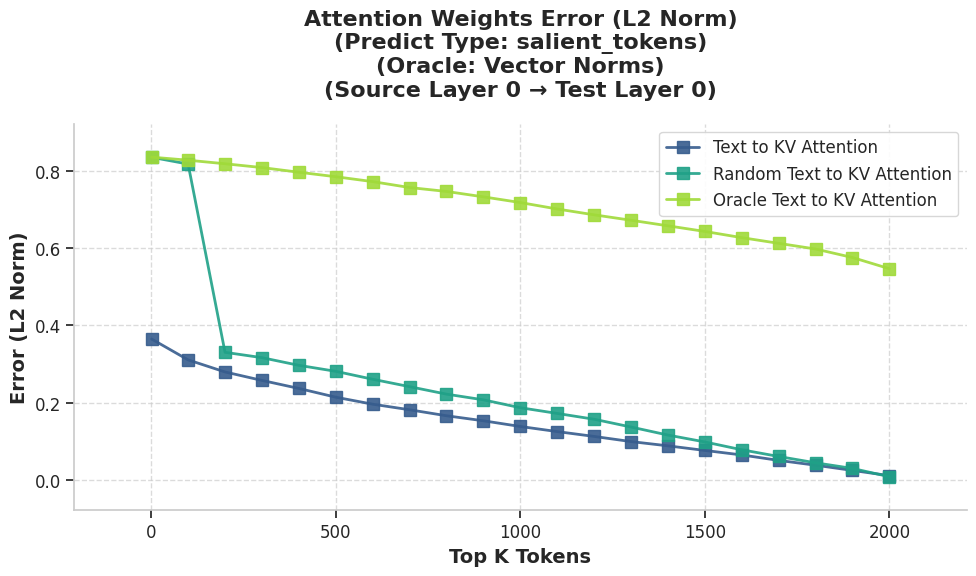

Analyzing all combinations:   3%|▎         | 2/72 [00:32<19:08, 16.41s/it]

Analyzing error_type: attention_weights, metric: l2_norm, predict_type: salient_tokens, oracle_type: attention_weighted_vector_norms


/tmp/ipykernel_2036673/2520924043.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  slident_value.append(weights.std().item() + weights.mean().item())
Analyzing top k tokens: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]


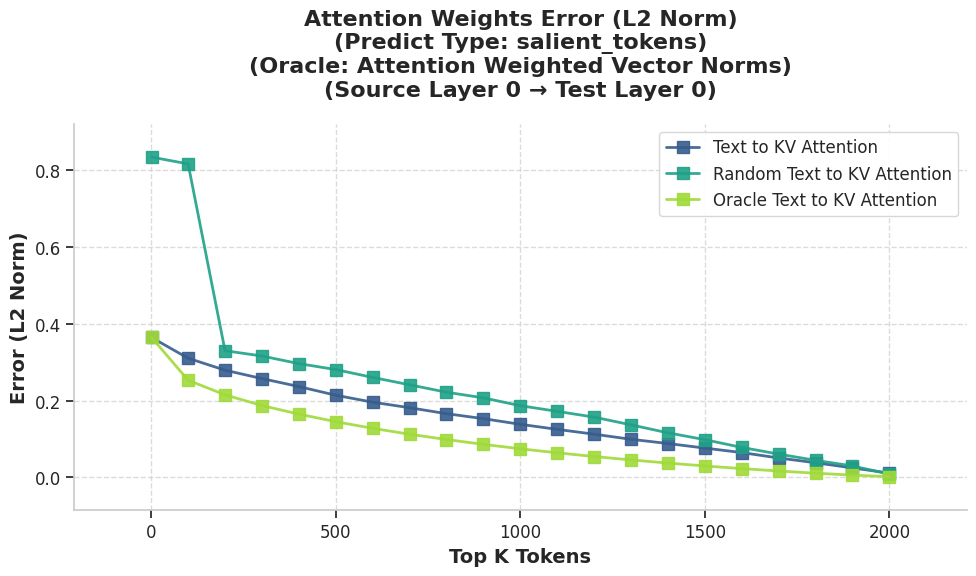

Analyzing all combinations:   4%|▍         | 3/72 [00:49<18:52, 16.41s/it]

Analyzing error_type: attention_weights, metric: l2_norm, predict_type: attention_weights, oracle_type: attention_weights


Analyzing all combinations:   4%|▍         | 3/72 [00:50<19:32, 16.99s/it]


KeyboardInterrupt: 

In [13]:
import prettytable as pt
from tqdm import tqdm
from itertools import product
import random
# use 31 layer to predict 31 layer, topk from 50, 100, 200, 500, 1000, 2000
source_layer_idx = 0
test_layer_idx = 0

all_combinations = list(product(
    ["attention_weights", "value_vectors"],
    ["l2_norm", "l-inf_norm", "cosine_similarity"],
    ["salient_tokens", "attention_weights", "vector_norms", "key_norms"],
    ["attention_weights", "vector_norms", "attention_weighted_vector_norms"]    
))
# error_type = "value_vectors" # attention_weights, value_vectors
# metric = "l-inf_norm" # l2_norm, l-inf_norm, cosine_similarity
# predict_type = "salient_tokens" # salient_tokens, attention_weights, vector_norms, key_norms
# oracle_type = "attention_weighted_vector_norms"
for error_type, metric, predict_type, oracle_type in tqdm(all_combinations, desc="Analyzing all combinations"):
    print(f"Analyzing error_type: {error_type}, metric: {metric}, predict_type: {predict_type}, oracle_type: {oracle_type}")

    all_top_k = [1] + list(range(100, 2100, 100))
    all_local_self_attn_error = []
    all_text_to_kv_error = []
    all_random_local_self_attn_error = []
    all_random_text_to_kv_error = []
    all_oracle_local_self_attn_error = []
    all_oracle_text_to_kv_error = []
    all_oracle_random_local_self_attn_error = []
    all_oracle_random_text_to_kv_error = []
    for top_k in tqdm(all_top_k, desc="Analyzing top k tokens"):
        random.seed(0)
        random_top_k_idxs = random.sample(range(local_self_attn[source_layer_idx].shape[0]), top_k)
        top_k_idxs = get_top_k_idxs_to_predict(source_layer_idx, top_k, do_print=False, predict_type=predict_type)
        oracle_top_k_idxs = get_oracle_top_k_idxs_to_predict(source_layer_idx, top_k, do_print=False, oracle_type=oracle_type)
        local_self_attn_error, text_to_kv_error = estimate_attention_error(test_layer_idx, top_k_idxs)
        all_local_self_attn_error.append(local_self_attn_error)
        all_text_to_kv_error.append(text_to_kv_error)
        random_local_self_attn_error, random_text_to_kv_error = estimate_attention_error(test_layer_idx, random_top_k_idxs, error_type=error_type, metric=metric)
        all_random_local_self_attn_error.append(random_local_self_attn_error)
        all_random_text_to_kv_error.append(random_text_to_kv_error)
        oracle_local_self_attn_error, oracle_text_to_kv_error = estimate_attention_error(test_layer_idx, oracle_top_k_idxs, error_type=error_type, metric=metric)
        all_oracle_local_self_attn_error.append(oracle_local_self_attn_error)
        all_oracle_text_to_kv_error.append(oracle_text_to_kv_error)
    # plot
    plot_top_k_error(source_layer_idx, test_layer_idx, all_top_k, 
        all_local_self_attn_error, all_text_to_kv_error, 
        all_random_local_self_attn_error, all_random_text_to_kv_error,
        all_oracle_local_self_attn_error, all_oracle_text_to_kv_error,
        error_type=error_type, metric=metric, oracle_type=oracle_type, predict_type=predict_type)

    pt_table = pt.PrettyTable()
    title = f"Attention Error Analysis (Source Layer {source_layer_idx} → Test Layer {test_layer_idx})(Error Type: {error_type}, Metric: {metric}, Oracle Type: {oracle_type}, Predict Type: {predict_type})"
    pt_table.title = title
    pt_table.field_names = ["Top K Tokens", "Local Self Attention Error", "Text to KV Attention Error", "Random Local Self Attention Error", "Random Text to KV Attention Error", "Oracle Local Self Attention Error", "Oracle Text to KV Attention Error"]
    for top_k, local_self_attn_error, text_to_kv_error, random_local_self_attn_error, random_text_to_kv_error, oracle_local_self_attn_error, oracle_text_to_kv_error in zip(all_top_k, all_local_self_attn_error, all_text_to_kv_error, all_random_local_self_attn_error, all_random_text_to_kv_error, all_oracle_local_self_attn_error, all_oracle_text_to_kv_error):
        pt_table.add_row([
            top_k,
            f"{local_self_attn_error:.5f}",
            f"{text_to_kv_error:.5f}",
            f"{random_local_self_attn_error:.5f}",
            f"{random_text_to_kv_error:.5f}",
            f"{oracle_local_self_attn_error:.5f}",
            f"{oracle_text_to_kv_error:.5f}",
        ])


In [ ]:
layer_idx = 31
top_k_to_print = 300
# analysis the tokens where the later tokens always have consistent attention weights
to_attend_weights_deltas = {}
for i in range(len(local_self_attn[layer_idx])):
    weights = text_to_kv_attn[layer_idx][:, i]
    # to_attend_weights_deltas[i] = weights.std().item()
    to_attend_weights_deltas[i] = weights.std().item() + weights.sum().item()
    # to_attend_weights_deltas[i] = ((weights - text_to_kv_attn[layer_idx][:, i-1] if i > 0 else weights) > 0).sum().item() # higher, the more previous tokens this token attends to 
    # to_attend_weights_deltas[i] = weights.sum().item() # higher, the more important this token is to the later tokens
    to_attend_weights_deltas[i] /= len(weights)

sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=True)
print(f"Top {top_k_to_print} tokens with the highest variance of attention weights")
for i, (idx, var) in enumerate(sorted_to_attend_weights_deltas[:top_k_to_print]):
    print(f"{idx} -> {tokens[idx].ljust(max_token_len)}: {var:.8f}")
    
# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]]
reproduced_weights = []
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i, top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"local attn error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))

# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
_top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]] + [i+local_self_attn[layer_idx].shape[0] for i in range(text_to_kv_attn[layer_idx].shape[0])] 
reproduced_weights = []
for i in range(len(text_to_kv_attn[layer_idx])):
    weights = text_to_kv_attn[layer_idx][i, _top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"text to kv error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))


Top 300 tokens with the highest variance of attention weights
0 -> <s>          : 0.40690629
1 -> <img>        : 0.00924715
248 -> <IMG_CONTEXT>: 0.00244625
9 -> <IMG_CONTEXT>: 0.00243960
259 -> <img>        : 0.00212712
2 -> <IMG_CONTEXT>: 0.00197462
1864 -> <IMG_CONTEXT>: 0.00194558
1544 -> <IMG_CONTEXT>: 0.00184910
17 -> <IMG_CONTEXT>: 0.00177913
8 -> <IMG_CONTEXT>: 0.00159963
24 -> <IMG_CONTEXT>: 0.00150676
83 -> <IMG_CONTEXT>: 0.00150414
3 -> <IMG_CONTEXT>: 0.00145910
275 -> <IMG_CONTEXT>: 0.00136283
506 -> <IMG_CONTEXT>: 0.00120089
257 -> <IMG_CONTEXT>: 0.00118645
14 -> <IMG_CONTEXT>: 0.00116722
67 -> <IMG_CONTEXT>: 0.00106262
517 -> <img>        : 0.00104740
5 -> <IMG_CONTEXT>: 0.00104687
4 -> <IMG_CONTEXT>: 0.00100556
1825 -> <IMG_CONTEXT>: 0.00098608
243 -> <IMG_CONTEXT>: 0.00091930
533 -> <IMG_CONTEXT>: 0.00091528
791 -> <IMG_CONTEXT>: 0.00085650
1022 -> <IMG_CONTEXT>: 0.00084752
7 -> <IMG_CONTEXT>: 0.00082012
1280 -> <IMG_CONTEXT>: 0.00081594
40 -> <IMG_CONTEXT>: 0.00079100
